In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Load the dataset**

In [2]:
try:
    df = pd.read_csv('data.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: data.csv not found. Please ensure the file is in the correct directory.")
    exit()

Dataset loaded successfully!


In [3]:
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_

---

# **Feature Engineering**

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

## **4.1. Processing Numerical Features**
### We will scale the numerical audio features to be between 0 and 1.

In [5]:
numerical_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
scaler = MinMaxScaler()
df_numerical_scaled = scaler.fit_transform(df[numerical_features])

## **4.2. Processing Categorical Features: Year -> Decade**
### Grouping years into decades can help capture the sound of different eras.

In [6]:
def get_decade(year):
    return f"{(year // 10) * 10}s"
df['decade'] = df['year'].apply(get_decade)
df_decades = pd.get_dummies(df['decade'])

## **4.3. Processing Text Features: Artists**
### The 'artists' column is text. We can use TF-IDF to convert artist names into a numerical format.
### This technique gives more weight to rare artists, which can make recommendations more specific.

In [7]:
df['artists_processed'] = df['artists'].str.replace(r"[\[\]']", "", regex=True) # Clean the string
tfidf = TfidfVectorizer(max_features=5000) # Limit to top 5000 artists to keep matrix manageable
df_artists_tfidf = tfidf.fit_transform(df['artists_processed'])

## **4.4. Combining All Features**
### Now, we combine all our processed features into a single sparse matrix. This is an efficient way to handle mixed data types.

In [8]:
combined_features = hstack([df_numerical_scaled, df_decades, df_artists_tfidf]).tocsr()
print("Shape of combined feature matrix:", combined_features.shape)

Shape of combined feature matrix: (170653, 5020)


---

# **Building the Recommendation Model**

In [9]:
from annoy import AnnoyIndex
import os

### Calculate the cosine similarity matrix

In [10]:
# Get the number of features from our combined matrix
num_features = combined_features.shape[1]

In [11]:
# Build the Annoy index
annoy_index = AnnoyIndex(num_features, 'angular')

In [12]:
print("Building Annoy index... (This may take some time)")
for i in range(combined_features.shape[0]):
    vector = combined_features.getrow(i).toarray()[0]
    annoy_index.add_item(i, vector)

annoy_index.build(10)
print("Annoy index built successfully!")

Building Annoy index... (This may take some time)
Annoy index built successfully!


In [13]:
# Save the index to a file for later use
index_file = 'song_recommendation.ann'
annoy_index.save(index_file)
print(f"Index saved to {index_file}")

Index saved to song_recommendation.ann


In [14]:
# Create a mapping from song name to index for easy lookup
song_name_to_index = pd.Series(df.index, index=df['name']).drop_duplicates()

---

# Creating the Recommendation Function

In [17]:
def get_recommendations_annoy(song_name, annoy_index_path, df, top_n=10):
    """
    Generates song recommendations using a pre-built Annoy index.

    Args:
        song_name (str): The name of the song to get recommendations for.
        annoy_index_path (str): Path to the saved Annoy index file.
        df (pd.DataFrame): The original dataframe with song information.
        top_n (int): The number of recommendations to return.

    Returns:
        pd.DataFrame or str: A dataframe of recommended songs or an error message.
    """
    if song_name not in song_name_to_index:
        return f"Error: Song '{song_name}' not found in the dataset."

    # Get the index for the input song
    song_index_val = song_name_to_index[song_name]
    
    # Handle cases where a song name maps to multiple indices (due to duplicates)
    # by taking the first one.
    if isinstance(song_index_val, pd.Series):
        song_index = song_index_val.iloc[0]
    else:
        song_index = song_index_val
        
    num_features = combined_features.shape[1]
    
    # Load the Annoy index from the file
    loaded_annoy_index = AnnoyIndex(num_features, 'angular')
    loaded_annoy_index.load(annoy_index_path)

    # Get the top N nearest neighbors. We ask for top_n + 1 to exclude the song itself.
    neighbor_indices = loaded_annoy_index.get_nns_by_item(song_index, top_n + 1)
    
    # Filter out the input song itself if it appears in the results
    top_songs_indices = [idx for idx in neighbor_indices if idx != song_index][:top_n]
    
    # Create a dataframe with the recommended songs and their artists
    recommendations = df.iloc[top_songs_indices][['name', 'artists']]
    return recommendations

---

# Testing the Recommender

## Example 1: A classic rock anthem

In [18]:
song_to_recommend = 'Bohemian Rhapsody - Remastered 2011'
recommendations = get_recommendations_annoy(song_to_recommend, 'song_recommendation.ann', df)
print(f"Recommendations for '{song_to_recommend}':")
print(recommendations)

Recommendations for 'Bohemian Rhapsody - Remastered 2011':
                                        name    artists
48386    Bohemian Rhapsody - Remastered 2011  ['Queen']
48257   The Prophet's Song - Remastered 2011  ['Queen']
131832  The Prophet's Song - Remastered 2011  ['Queen']
29625                      Bohemian Rhapsody  ['Queen']
66106                     The Prophet's Song  ['Queen']
83555                                 Drowse  ['Queen']
100048                             Long Away  ['Queen']
11088                   We Are The Champions  ['Queen']
131406       My Fairy King - Remastered 2011  ['Queen']
146259       My Fairy King - Remastered 2011  ['Queen']


## Example 2: A modern pop song

In [19]:
song_to_recommend = 'Blinding Lights'
recommendations = get_recommendations_annoy(song_to_recommend, 'song_recommendation.ann', df, top_n=5)
print(f"\nRecommendations for '{song_to_recommend}':")
print(recommendations)


Recommendations for 'Blinding Lights':
                                  name         artists
38467                        Heartless  ['The Weeknd']
140723                       Snowchild  ['The Weeknd']
140724                  Escape From LA  ['The Weeknd']
140756  Nothing Compares - Bonus Track  ['The Weeknd']
57218                      After Hours  ['The Weeknd']


## Example 3: A song that is not in the dataset

In [20]:
song_to_recommend = 'Non Existent Song'
recommendations = get_recommendations_annoy(song_to_recommend, 'song_recommendation.ann', df)
print(f"\nRecommendations for '{song_to_recommend}':")
print(recommendations)


Recommendations for 'Non Existent Song':
Error: Song 'Non Existent Song' not found in the dataset.


---

# Model Evaluation

Evaluating a recommender system is different from standard classification or regression models. We can't use metrics like accuracy directly. Instead, we measure the quality of recommendations using metrics like **Precision@k**.

**Precision@k** answers the question: "Out of the `k` songs we recommended, how many were relevant?"

To define "relevance" without user feedback, we can use a proxy: we'll assume that other songs by the same artist are relevant. So, if we ask for recommendations for a Queen song, we check how many of the top 10 recommendations are also by Queen. A high score means the model correctly identifies an artist's style.

In [32]:
def calculate_precision_at_k(df, annoy_index_path, test_sample_size=1000, k=10):
    """
    Calculates the average Precision@k for a sample of songs.
    """
    precisions = []
    
    # Take a random sample of songs to test
    test_indices = np.random.choice(df.index, size=test_sample_size, replace=False)
    
    for i, song_index in enumerate(test_indices):
        song_name = df.iloc[song_index]['name']
        original_artist = df.iloc[song_index]['artists']
        
        # Get recommendations
        recommendations = get_recommendations_annoy(song_name, annoy_index_path, df, top_n=k)
        
        if isinstance(recommendations, pd.DataFrame) and not recommendations.empty:
            # Count how many recommended songs are by the same artist
            relevant_items_count = recommendations[recommendations['artists'] == original_artist].shape[0]
            
            # Calculate precision for this song
            precision = relevant_items_count / k
            precisions.append(precision)
            
    # Return the average precision across all test songs
    return np.mean(precisions)

# Run the evaluation
print("\n--- Model Evaluation ---")
avg_precision = calculate_precision_at_k(df, 'song_recommendation.ann')
print(f"Average Precision@10 for the model is: {avg_precision:.4f}")
print("This means that, on average, if we recommend 10 songs, about {:.1f} of them will be from the same artist as the input song.".format(avg_precision * 10))



--- Model Evaluation ---
Average Precision@10 for the model is: 0.4568
This means that, on average, if we recommend 10 songs, about 4.6 of them will be from the same artist as the input song.


---

# Advanced Visualization with t-SNE

In [23]:
from sklearn.manifold import TSNE

In [24]:
# We'll take a random sample of the data to speed up t-SNE
sample_size = 2000
random_indices = np.random.choice(combined_features.shape[0], size=sample_size, replace=False)
sample_features = combined_features[random_indices, :]
sample_df = df.iloc[random_indices]

In [28]:
print("\nRunning t-SNE... (This is computationally intensive)")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=300,  # changed from n_iter
    random_state=42
)
tsne_results = tsne.fit_transform(sample_features.toarray())


Running t-SNE... (This is computationally intensive)


### Create a dataframe for plotting

In [29]:
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['popularity'] = sample_df['popularity'].values
tsne_df['decade'] = sample_df['decade'].values

### Plot the t-SNE results, coloring by decade

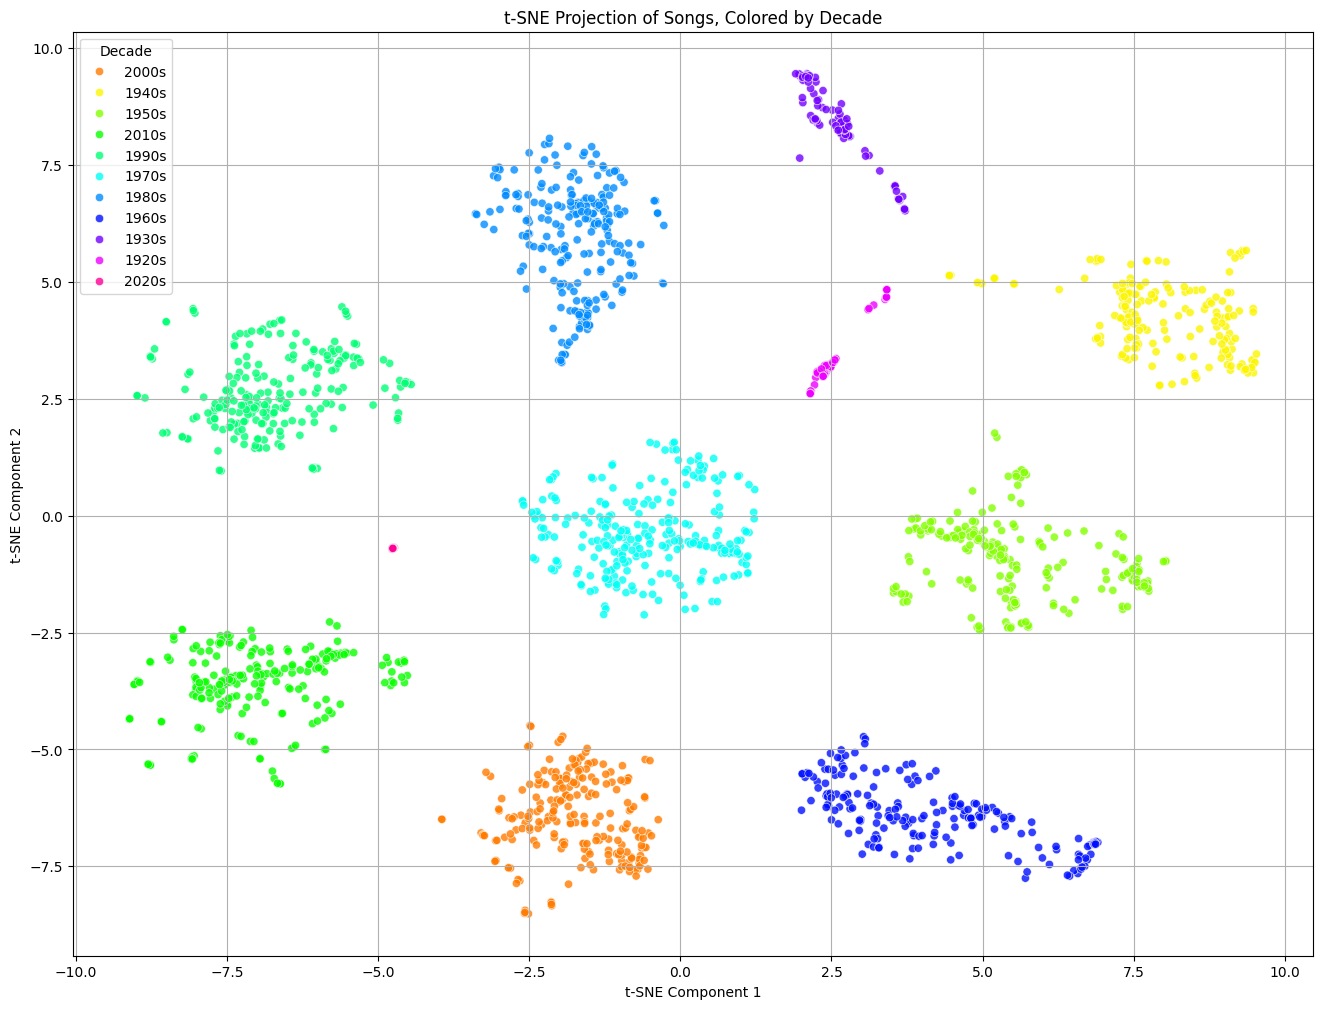

In [31]:
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue='decade',
    palette=sns.color_palette("hsv", n_colors=len(tsne_df['decade'].unique())),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Projection of Songs, Colored by Decade')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Decade')
plt.grid(True)
plt.show()

The plot shows that songs from the same decade tend to cluster together, which indicates that our feature engineering successfully captured era-specific musical styles. This visual evidence supports the effectiveness of our content-based approach.

The system combines three different types of information to find similar songs:

### 1. Audio Features
This is the core of the system. It uses nine numerical features like **danceability**, **energy**, **acousticness**, and **tempo** to understand the actual sound and feel of a song.

### 2. Artist Information
It also considers the song's **artist**. This helps recommend other songs by the same or similar artists.

### 3. Decade
The **year** is grouped into **decades** (e.g., 1980s, 1990s) to capture the general "sound" of that era.

---

The **t-SNE plot** you highlighted is just a way to visualize how well the model is working. We colored the dots by **decade** to check if our combined features were good enough to group songs from similar eras together. The fact that they cluster nicely shows that our **feature engineering was successful** and the model is capturing **meaningful patterns beyond just the year**.
